In [160]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import numpy as np

In [161]:
df = pd.read_csv("SwimDataTop50.csv",";")

C:\Users\lukas\AppData\Local\Temp\ipykernel_6944\3450534495.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  df = pd.read_csv("SwimDataTop50.csv",";")


In [162]:

# Function to parse time strings with variable formats
def parse_custom_time(time_str):
    format = len(str(time_str).split(":"))

    if format == 1:
        return pd.to_timedelta(f'00:00:{time_str}')
    elif format == 2:
        return pd.to_timedelta(f'00:{time_str}')
    elif format == 3:
        return pd.to_timedelta(time_str)



# Convert 'time' column to timedelta using the custom function
df['time'] = df['time'].apply(parse_custom_time)

df['time_seconds'] = df['time'].dt.total_seconds()

df['speed'] = df['distance'] / df['time_seconds']

In [163]:

# Group the data by 'surname', 'firstname', 'track length', 'technique'
grouped_data = df.groupby(['surname', 'firstname', 'track length', 'technique'])

grouped_data.size()

# Function to fit a regression model and plot the results
def plot_regression(distance, speed, ax, title):
    if len(distance) == 2:
        model = LinearRegression()
    else:
        model = make_pipeline(PolynomialFeatures(2), LinearRegression())
        
    model.fit(distance.values.reshape(-1, 1), speed)

    x_range = np.linspace(distance.min(), distance.max(), 100).reshape(-1, 1)
    y_pred = model.predict(x_range)

    ax.scatter(distance, speed, color='blue', label='Data')
    ax.plot(x_range, y_pred, color='red', label='Regression Curve')
    ax.set_title(title)
    ax.set_xlabel('Distance (m)')
    ax.set_ylabel('Speed (m/s)')
    ax.legend()

# Function to filter data for a specific swimmer and plot the regression
def plot_regression_for_swimmer(df, firstname, lastname):
    filtered_df = df[(df['firstname'] == firstname) & (df['surname'] == lastname)]

    if filtered_df.empty:
        print(f"No data found for {firstname} {lastname}.")
        return

    grouped_data = filtered_df.groupby(['track length', 'technique'])

    for (track_length, technique), group in grouped_data:
        print(group)
        plt.figure(figsize=(10, 6))
        plot_regression(group['distance'], group['speed'], plt.gca(), f"Regression for {firstname} {lastname} ({track_length}m track, {technique})")
        plt.show()

    surname firstname  distance technique  track length  \
29  LEDECKY  Kathleen       200  Freistil            25   
31  LEDECKY  Kathleen       400  Freistil            25   
33  LEDECKY  Kathleen       800  Freistil            25   
35  LEDECKY  Kathleen      1500  Freistil            25   
44  LEDECKY  Kathleen       100  Freistil            25   

                     time  time_seconds     speed  
29 0 days 00:01:52.100000        112.10  1.784121  
31 0 days 00:03:52.880000        232.88  1.717623  
33 0 days 00:07:57.420000        477.42  1.675673  
35 0 days 00:15:08.240000        908.24  1.651546  
44        0 days 00:00:54         54.00  1.851852  


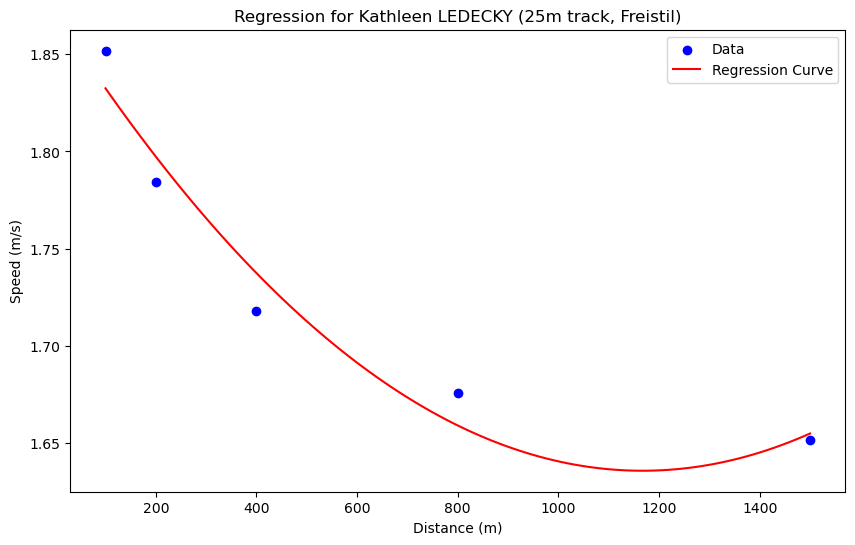

    surname firstname  distance technique  track length  \
42  LEDECKY  Kathleen       400     Lagen            25   

                     time  time_seconds     speed  
42 0 days 00:04:27.180000        267.18  1.497118  


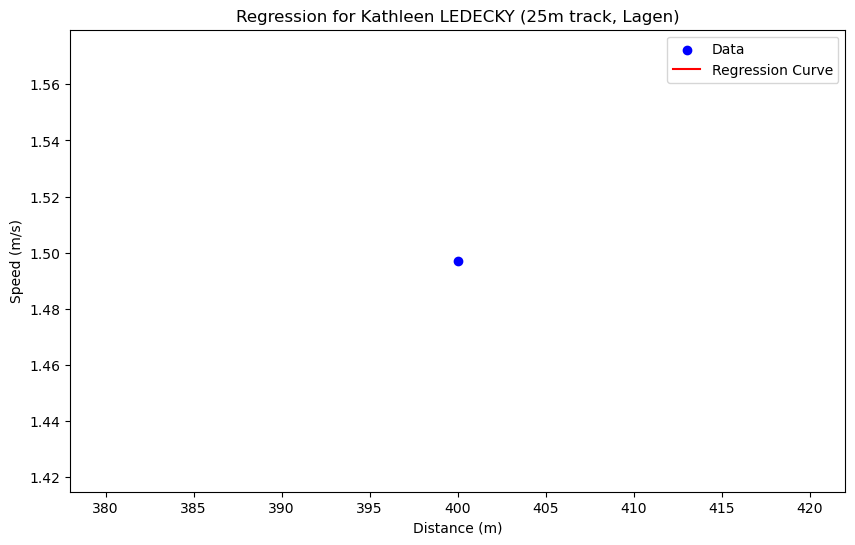

    surname firstname  distance      technique  track length  \
39  LEDECKY  Kathleen       200  Schmetterling            25   

                     time  time_seconds     speed  
39 0 days 00:02:13.080000        133.08  1.502855  


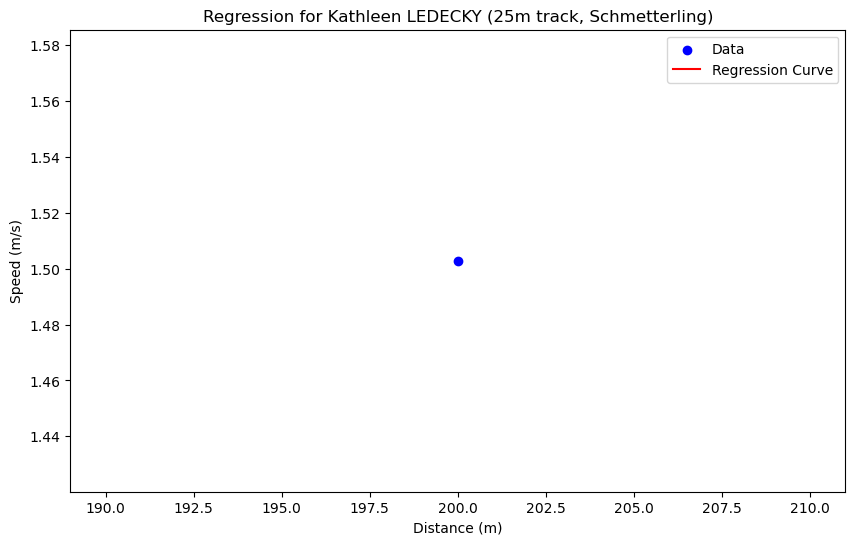

    surname firstname  distance technique  track length  \
26  LEDECKY  Kathleen        50  Freistil            50   
27  LEDECKY  Kathleen       100  Freistil            50   
28  LEDECKY  Kathleen       200  Freistil            50   
30  LEDECKY  Kathleen       400  Freistil            50   
32  LEDECKY  Kathleen       800  Freistil            50   
34  LEDECKY  Kathleen      1500  Freistil            50   
43  LEDECKY  Kathleen       100  Freistil            50   
45  LEDECKY  Kathleen       200  Freistil            50   

                     time  time_seconds     speed  
26 0 days 00:00:25.450000         25.45  1.964637  
27 0 days 00:00:53.750000         53.75  1.860465  
28 0 days 00:01:53.730000        113.73  1.758551  
30 0 days 00:03:56.460000        236.46  1.691618  
32 0 days 00:08:04.790000        484.79  1.650199  
34 0 days 00:15:20.480000        920.48  1.629585  
43 0 days 00:00:52.640000         52.64  1.899696  
45 0 days 00:01:53.670000        113.67  1.759479  


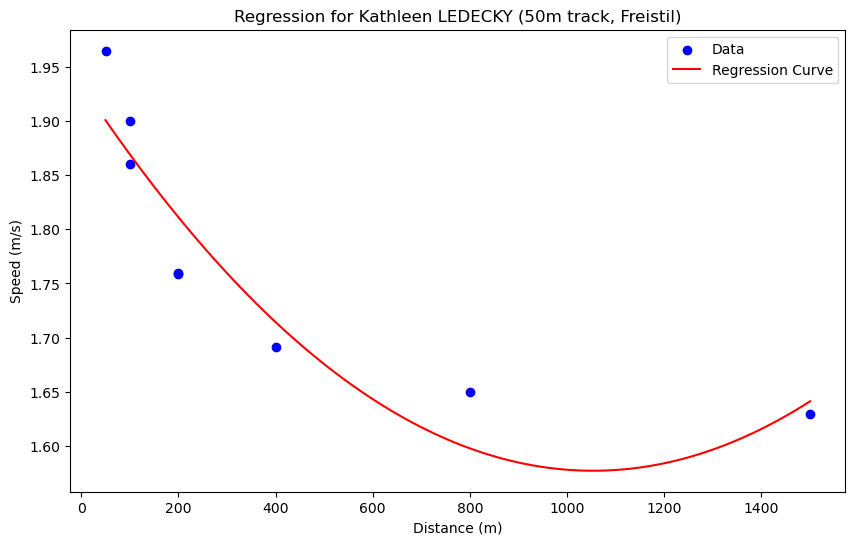

    surname firstname  distance technique  track length  \
40  LEDECKY  Kathleen       200     Lagen            50   
41  LEDECKY  Kathleen       400     Lagen            50   

                     time  time_seconds     speed  
40 0 days 00:02:14.360000        134.36  1.488538  
41 0 days 00:04:35.770000        275.77  1.450484  


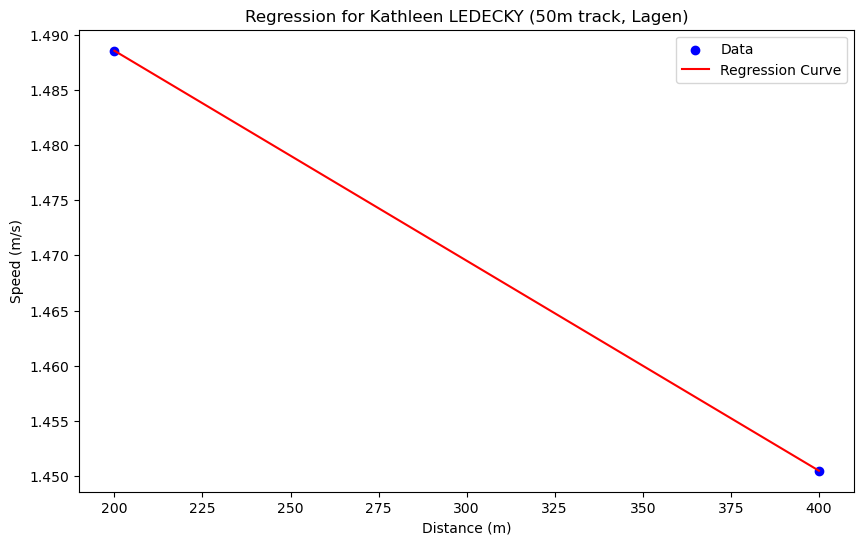

    surname firstname  distance technique  track length  \
36  LEDECKY  Kathleen       100    Rücken            50   

                     time  time_seconds     speed  
36 0 days 00:01:04.580000         64.58  1.548467  


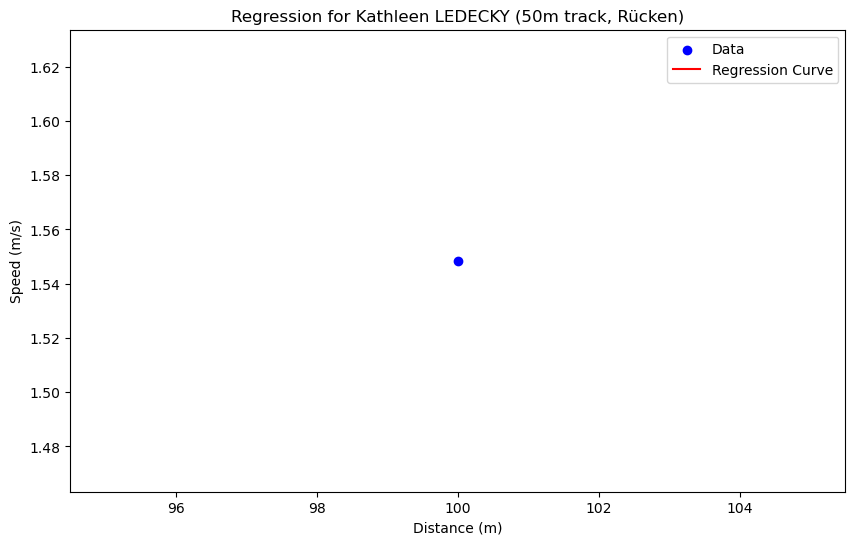

    surname firstname  distance      technique  track length  \
37  LEDECKY  Kathleen       100  Schmetterling            50   
38  LEDECKY  Kathleen       200  Schmetterling            50   

                     time  time_seconds     speed  
37 0 days 00:01:02.010000         62.01  1.612643  
38 0 days 00:02:13.770000        133.77  1.495104  


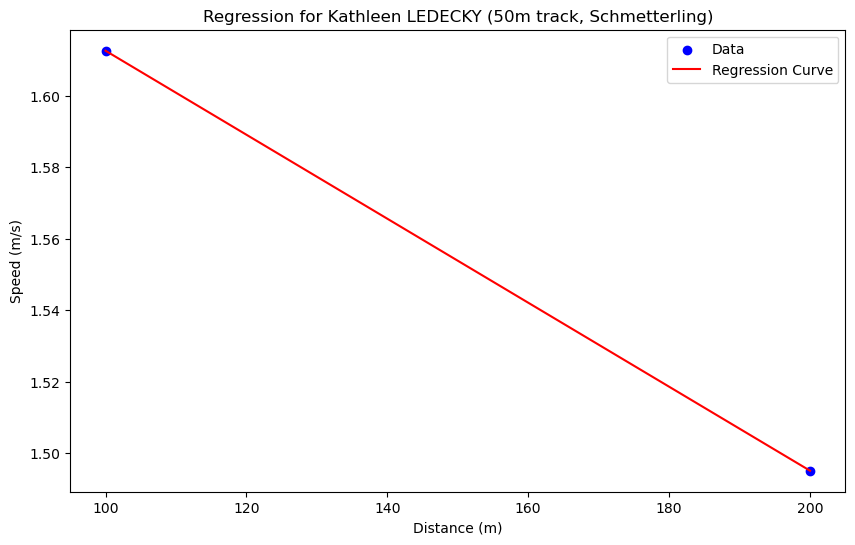

In [164]:
plot_regression_for_swimmer(df, firstname='Kathleen', lastname='LEDECKY')